In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# The Ising model in 2D
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours. 

<img src="attachment:image.png" width="250"> 


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours. 

<img src="attachment:image.png" width="250"> 


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. 

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [3]:
def create_initial_config(N=None):
    #spin

    config = np.random.choice([-1,1],size=(N,N))
    return config

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [4]:
%%time

config = create_initial_config(N=100)

Wall time: 0 ns


To plot our system we can use `plt.imshow()`, as follows:

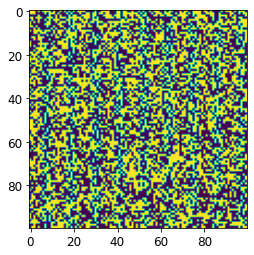

In [5]:
plt.imshow(config);

### Exercise 4.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

$$
\Delta E = 2s(i,j)(s(i+1,j)+s(i-1,j)+s(i,j+1)+s(i,j-1))
$$

### Exercise 4.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [7]:
%%time

def metropolis_single_update(config=None, T=None):
    '''
    Do a single Monte Carlo update using Metropolis algorithm.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The current configuration.
    T : float
        The temperature.

    '''
    # make sure config is square
    N, M = config.shape
    assert N==M
    
    # choose random site
    i = np.random.randint(0,N)
    j = np.random.randint(0,N)
    s =  config[i, j]
        
    # compute energy cost of flip
    # DeltaE is the possible energy cost
    DeltaE = 2*s*(config[(i+1)%N,j]+config[(i-1)%N,j]+config[i,(j-1)%N]+config[i,(j+1)%N])

    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE < 0:
        # flip the sping
        s *= -1
        # set effective DeltaE to DeltaE 
        effDeltaE = DeltaE
        
    # case DeltaE >= 0
    else:
        # flip the spin with certain probability
        if np.random.uniform()<np.exp(-DeltaE/T):
            # flip the sping
            s *= -1
            # set effective Delta E 
            effDeltaE = DeltaE
        
    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s 
    #
    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

Wall time: 0 ns


## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size. 

Wall time: 7.2 s


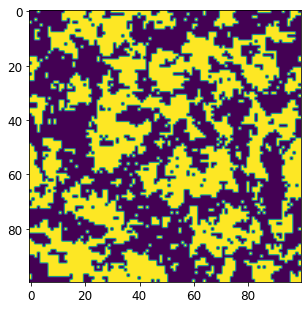

In [8]:
%%time

T_c = 2/np.log(1+np.sqrt(2))

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)

for t in range(100000):
    # update the system
    DeltaE = metropolis_single_update(config, T=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice 4.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [9]:
%%time

def get_energy(config):
    """
    Compute the energy of a configuration.
    
    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.
        
        
    Returns
    -------
    E : float
        The energy of the configuration.
    """
    
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    
    horizontal_edges = [
        (i, j, i, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    
    vertical_edges = [
        (i, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]
    
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    
    return E    

Wall time: 0 ns


In [10]:
#prova

energy=get_energy(config)
print(energy)

-11876


In [11]:
%%time

def get_energy_evolution(N=20, T=T_c, n_updates=50000):
    """
    Compute the energy evolution of a 2D Ising instance.
    
    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.
        
    Returns
    -------
    Es : np.array, (n_updates, )
    """
    config = create_initial_config(N)
    Es=np.zeros(n_updates)
    
    for i in range (n_updates):
        Es[i]=get_energy(config)
        dE=metropolis_single_update(config, T)
    
    return Es

Wall time: 0 ns


### Exercise 4.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [12]:
%%time

energy_evolution = get_energy_evolution(N=10, T=0.01, n_updates=10000)

Wall time: 818 ms


Wall time: 12.9 ms


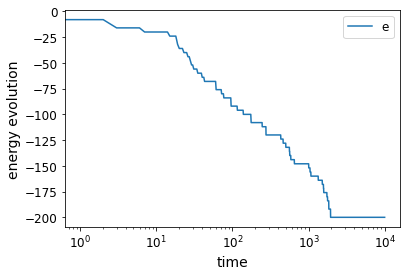

In [13]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.semilogx(energy_evolution)

ax.set_xlabel("time")
ax.set_ylabel("energy evolution")
ax.legend("energy variation")

### Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

*Your answer here*  sì, corrispondo ad una transizione di fase RIVEDERE!

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [14]:
import sys
sys.path.append("../code/")
from ising_sethna import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [15]:
%%time 

# create an instance of IsingModel
ising = IsingModel(N=100)

Wall time: 1 ms


In [16]:
%%time

# the state of the system is stored in .lattice
ising.lattice

Wall time: 0 ns


array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

Wall time: 14 ms


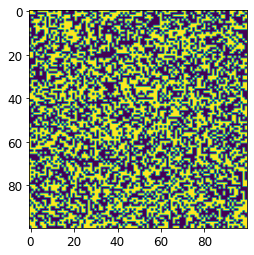

In [17]:
%%time

mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [18]:
%%time

ising.SweepMetropolis(nTimes=100)

Wall time: 2.75 s


Wall time: 37 ms


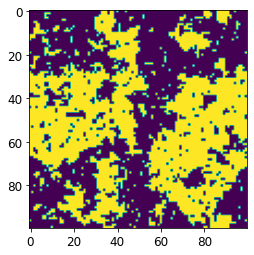

In [19]:
%%time

plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [20]:
%%time

#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

Wall time: 999 µs


Wall time: 24.9 s


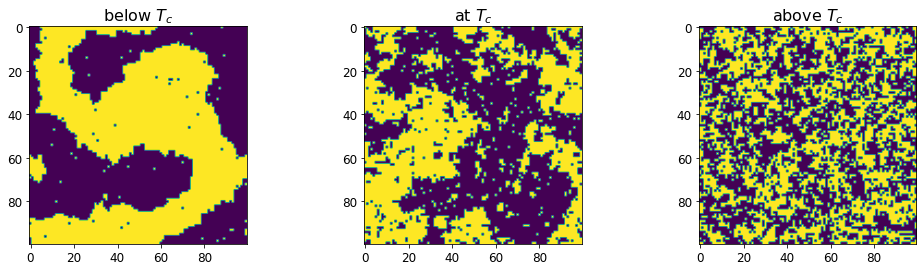

In [21]:
%%time

fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Exercice 4.7
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute.

To do a fair comparison, remember to take into account what "one update" means for each case.

In [22]:
%%time
%%timeit
# your Ising implementation running for some number of updates
n_updates=40000
config=create_initial_config(N=10)
for i in range(n_updates):
    dE=metropolis_single_update(config, T=T_c)

358 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Wall time: 2.87 s


In [23]:
%%time
%%timeit
# Sethan's implementation running for some **equivalent** number of updates
n_sweeps=100
ising=IsingModel(N=10, T=T_c, H=0.0)
for i in range(n_sweeps):
    ising.SweepMetropolis(nTimes=1)

30.5 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Wall time: 2.47 s


L'algoritmo si Sethna è circca 10 volte più veloce di quello implementato sopra

## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise 4.8
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

In [24]:
%%time

# set system size, temperature
system_size = 100
T=1.5
H=0
agg=10 #numero di aggiornamenti
ising=IsingModel(N=system_size, T=T, H=H)

# run some Wolff sweeps, check if equilibrium
x=np.array([i for i in range(agg)])
Sweep=[]
for i in range(agg):
    Sweep.append(ising.SweepWolff(nTimes=1))

Wall time: 580 ms


Text(0.5, 1.0, '2d Ising evolution')

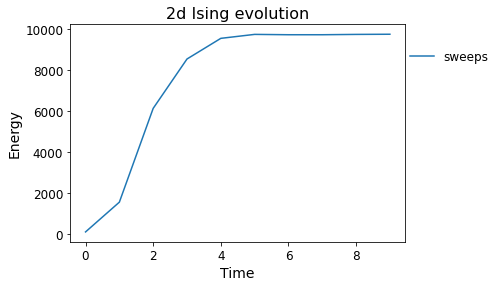

In [25]:
fig, ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(x, Sweep, label='sweeps')
ax.set_xlabel('Time')
ax.set_ylabel('Energy')
ax.legend(loc=(1,0.8), frameon=False)
ax.set_title('2d Ising evolution')

L'equilibrio viene raggiunto con all'incirca 10 step

### Exercise 4.9
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [26]:
%%time

def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # instantiate model
    ising = IsingModel(system_size, temperature)
    plt.imshow(ising.lattice)
    
    # equilibrate
    ising.SweepWolff(nTimes=equilibration_time)
    lattice=ising.lattice*2-1
    # compute magnetization
    m=np.sum(lattice) #la magnetizzazione complessiva è data dalla somma dei momenti magnetici
    
    return m

Wall time: 0 ns


10000

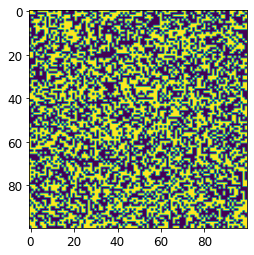

In [27]:
#prova

calculate_magnetization(100,0.1,100)

### Exercise 4.10
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

Wall time: 13.6 s


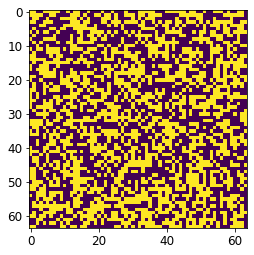

In [28]:
%%time

# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=100)
# system size
system_size = 64
# equilibration time
equilibration_time = 10

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = calculate_magnetization(system_size, temperature, equilibration_time)
    magnetizations.append(magnetization)

Wall time: 15.2 ms


Text(0, 0.5, '$|M|$')

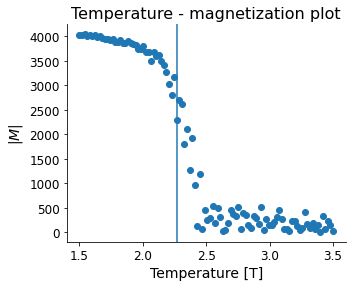

In [29]:
%%time

# define critical temperature
T_c = 2/np.log(1+np.sqrt(2))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures, np.abs(magnetizations),
    # style keywords
    #s=area, c=colors, edgecolors=colors
)
ax.axvline(
    T_c, 0, 1
    # style keywords
    #c=..., lw=..., ls=...
)
ax.set_title("Temperature - magnetization plot")
ax.set_xlabel('Temperature [T]')
ax.set_ylabel('$|M|$')

## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

$$
\chi= \left\langle (M - \langle M \rangle)^2 \right\rangle
$$

### Exercise 4.12
Write a function that computes the energy of an Ising configuration.

As usually, you can use the **template** below if it helps you, or if you prefer you can also write **your own function** from scratch.

In [30]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    config = ising.lattice*2-1
    N = len(config)
    
    #da 4.4
    horizontal_edges = [
        (i, j, i, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    
    vertical_edges = [
        (i, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]
    
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    return E / N**2

In [31]:
#prova

x=compute_energy(ising)
print(x)

-1.9596


### Exercise 4.13
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [32]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temeperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    
    ising=IsingModel(system_size,temperature)
    # thermalize
    for i in range(equilibration_time):
        ising.SweepWolff()
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for i in range(n_samples):
        # change notation from 0,1 to -1,1
        config = ising.lattice*2-1
        # get magnetization
        m = (np.sum(config))/(system_size**2)
        ms.append(m)
        m2s.append(m**2)
        # get energy
        E=compute_energy(ising) #get_energy
        es.append(E)
        e2s.append(E**2)
        ising=IsingModel(system_size,temperature)
        # thermalize
        for i in range(equilibration_time):
            ising.SweepWolff()
        
    N=system_size
    # compute susceptibility and specific heat
    susceptibility = (np.average(m2s)-(np.average(m))**2)*(N**2)
    specific_heat = (np.average(e2s)-(np.average(E))**2)*(N*2)/(temperature**2)
    
    return susceptibility, specific_heat

In [33]:
%%time

#prova
calculate_susceptibility_specific_heat(50, temperature=1.5, equilibration_time=10, n_samples=100)

Wall time: 15 s


(5.551115123125783e-13, 0.0)

### Exercise 4.14
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [34]:
%%time

# define range of temperatures: 50 points from 1.5 to 4.
temperatures = np.linspace(1.5, 3.5, num=50)
# system size
system_size = 50
# equilibration time
equilibration_time = 10
# n_samples
n_samples = 100

specific_heat = []
susceptibility = []

# loop over temperatures, compute susceptibility and specific_heat
for temperature in temperatures:
    heat_suscept = calculate_susceptibility_specific_heat(system_size, temperature, equilibration_time, n_samples)
    specific_heat.append(heat_suscept[0])
    susceptibility.append(heat_suscept[1])


Wall time: 8min 36s


Text(0.5, 1.0, '$C_v(T)$')

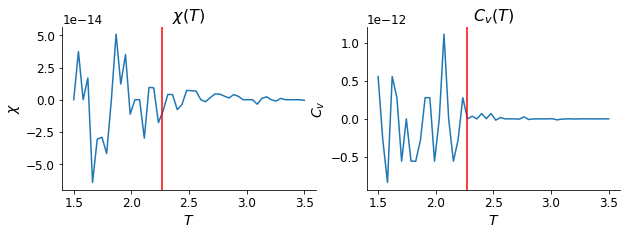

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax=ax1
ax.plot(temperatures,susceptibility)
ax.axvline(x=T_c, c='r', lw=1.5, ls='-')
ax.set_ylabel("$\chi$")
ax.set_xlabel("$T$")
ax.set_title("$\chi(T)$")

ax=ax2
ax.plot(temperatures,specific_heat)
ax.axvline(x=T_c, c='r', lw=1.5, ls='-')
ax.set_ylabel("$C_v$")
ax.set_xlabel("$T$")
ax.set_title("$C_v(T)$")


### Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

Dal grafico si osserva un brusco cambaimento di comportamento a partire da un valore critico di temperatura, in corrispondenza della temperatura critica avviene un cambiamento di fase.

# Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

<img src="attachment:image.png" width="600">

### Exercise 4.16
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

### Exercise 4.17
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.

<img src="attachment:image.png" width="600">

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [36]:
def control_neigh(config, i , j):
    N=len(config)
    neighbours=np.array([[(i-1)%N,j%N], [(i+1)%N,j%N], [i%N, (j-1)%N], [i%N, (j+1)%N]])
    parallels=[]
    for ind in neighbours:
        if config[ind[0],ind[1]]==config[i%N,j%N]:
            parallels.append(ind)
    return parallels

In [37]:
def get_labels(config):
    """
    Get unique cluster labels.
    
    Parameters
    ----------
    config : np.array, (N, N)
        Configuration of the system in {-1, 1} notation
    Returns
    -------
    labels : np.array, (N, N)
        Labels that identify the clusters
    """
    N=len(config)
    labels=np.zeros((N,N))
    h=0
    for i in range(N):
        for j in range (N):
            labels[i,j]+=h
            h+=1
    times=1
    oldtimes=1
    while times!=0 or oldtimes!=0:
        oldtimes=times
        times=0
        for i in range (N):
            for j in range(N):
                parallels=control_neigh(config, i , j)
                if len(parallels)!=0:
                    array=np.zeros(len(parallels)+1)
                    k=0
                    for ind in parallels:
                        array[k]=labels[ind[0],ind[1]]
                        k+=1
                    array[k]=labels[i,j]
                    minimum=np.amin(array)
                    if  labels[i,j]>minimum:
                        labels[i,j]=minimum
                    for ind in parallels:
                        if labels[ind[0],ind[1]]>minimum:
                            labels[ind[0],ind[1]]=minimum
                            times+=1
    n=0
    for m in range(N**2):
        if np.any(labels==m):
            labels=np.where(labels==m, n, labels)
            n+=1
                
    return labels

### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [38]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])

In [39]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])

In [40]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])


Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

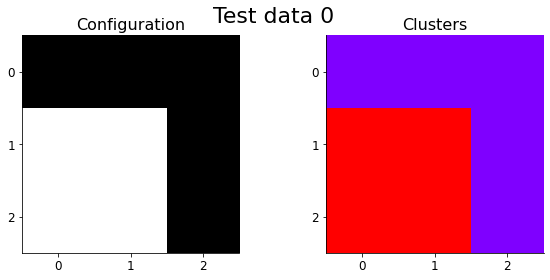

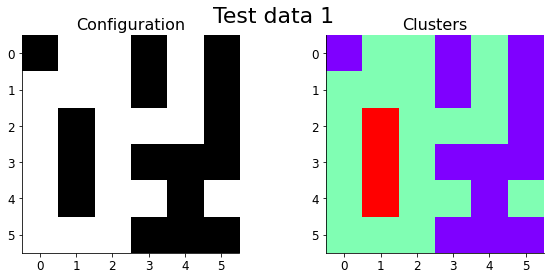

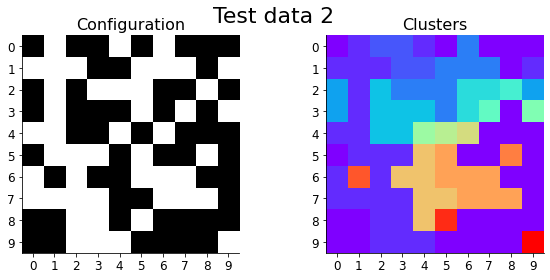

In [41]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = get_labels(config)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)

If your function doesn't work, you might want to use this cell to inspect your results

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

Wall time: 1min 26s


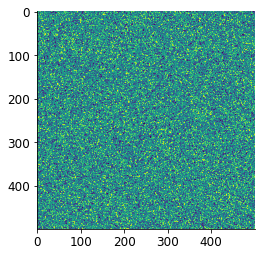

In [42]:
%%time

# set system size, temperature
system_size = 500
T=0.5
H=0

ising=IsingModel(N=system_size, T=T, H=H)
plt.imshow(ising.lattice)
config = ising.lattice*2-1
labels = get_labels(config)

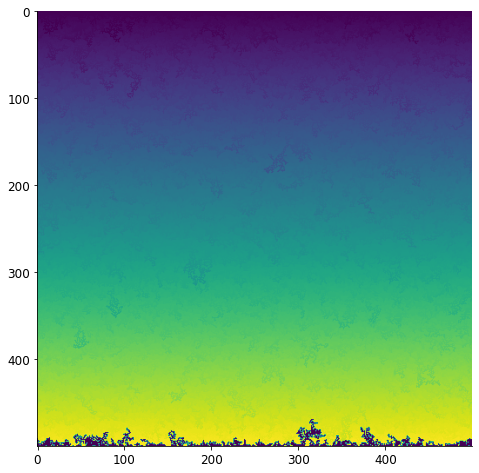

In [43]:
plt.figure(figsize=(10, 8))
plt.imshow(labels)

### Exercise 4.18
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [44]:
from collections import Counter

def get_sizes(labels):
    sizes = np.unique(labels, return_counts=True)[1]
    return sizes

### Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

Se gli spin sono non-corrlati e $T>>T_c$, ci sarranno soprattutto cluster di dimensione 1 quindi mi aspetto una distribuzione centrata in 1 ceh sia esponenzialmente decrescente.

### Exercice 4.20
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

La simulazione conferma quanto espresso in precedenza, infatti nel grafico in scala logaritmica l'andamento con esponenziale decrescente è rappresentato da una retat con pendenza negativa.

In [45]:
import sys 

sys.setrecursionlimit(1000000)
print(sys.getrecursionlimit())

1000000


Wall time: 3.08 s


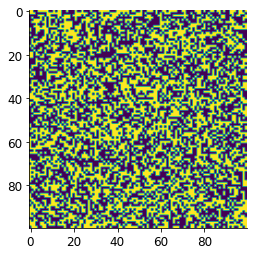

In [61]:
%%time
system_size = 100
T=10000
H=0
equilibration_time=10

for i in range(equilibration_time):
    sweep=ising.SweepWolff(nTimes=1)
    sweepC=isingC.SweepWolff(nTimes=1)

ising=IsingModel(N=system_size, T=T, H=H)
plt.imshow(ising.lattice)
config = ising.lattice*2-1
labels = get_labels(config)
sizes = get_sizes(labels)

(1, 267)

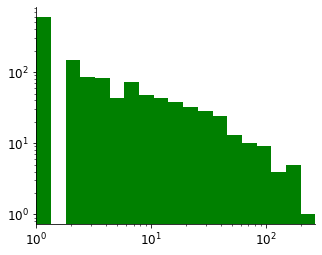

In [64]:
# use logarithmic bins and logarithmic axes!
bins = np.geomspace(min(sizes), max(sizes), num=20)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, histtype="stepfilled", color="green")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizes), max(sizes))

### Exercise 4.21

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

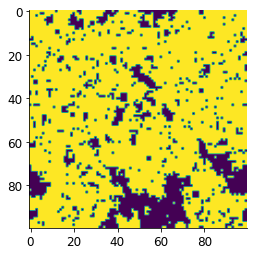

In [56]:
# do simulation
equilibration_time=10
system_size = 100
T_c = 2/np.log(1+np.sqrt(2))
H=0

ising=IsingModel(N=system_size, T=500*T_c, H=H)
isingC = IsingModel(N=system_size, T=T_c, H=H)

for i in range(equilibration_time):
    sweep=ising.SweepWolff(nTimes=1)
    sweepC=isingC.SweepWolff(nTimes=1)

config = ising.lattice*2-1
labels = get_labels(config)
sizes = get_sizes(labels)

plt.imshow(isingC.lattice)
configC = isingC.lattice*2-1
labelsC = get_labels(configC)
sizesC = get_sizes(labelsC)

(1, 8027)

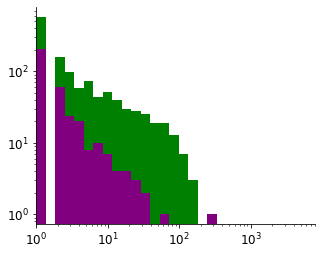

In [60]:
# plot results
bins = np.geomspace(min(sizes), max(sizes), num=20)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, histtype="stepfilled", color="green")
ax.hist(sizesC, bins=bins, histtype="stepfilled", color="purple")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizes), max(sizesC))